# **Histopathologic Cancer Detection (Kaggle)**

### **Project Objective**

To build a deep learning model that accurately identifies metastatic cancer tissue in 96x96px histopathologic image patches. The model must predict the probability that the center 32x32px region contains tumor tissue.

**Competition Metric:** ROC AUC

### **Project Workflow**

This notebook is designed to be flexible and supports two distinct run modes, managed by the CFG class:

1. **Training (on Google Colab Pro):**  
   * Set CFG.TRAINING \= True and CFG.INFERENCE \= False.  
   * Run on Colab Pro with high-performance GPUs (V100/A100) and High-RAM.  
   * Data will be downloaded via the Kaggle API to the local Colab VM.  
   * This mode will run the full K-Fold training and save the resulting model weights.  
   * Model weights (.h5 or .pth) should be manually saved (e.g., to Google Drive) and then uploaded as a private **Kaggle Dataset**.  
2. **Inference (on Kaggle Notebooks):**  
   * Set CFG.TRAINING \= False and CFG.INFERENCE \= True.  
   * This notebook will be run on the Kaggle platform for submission.  
   * It will **not** run training.  
   * It will load the pre-trained model weights from the private Kaggle Dataset created in Step 1\.  
   * It will run inference (with TTA) on the official test/ dataset and generate submission.csv.

## 1. Setup & Configuration
Import libraries and set system configuration

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras  # 导入 Keras 3.0
from sklearn.model_selection import train_test_split

# --- 1. 配置 ---

# 设置 Keras 3.0 后端为 TensorFlow
# 你需要在导入 keras 之前设置这个环境变量
os.environ["KERAS_BACKEND"] = "tensorflow"

# 全局常量，用于快速迭代
# 竞赛的图像尺寸是 96x96
IMAGE_SIZE = 96
# 鉴于你的 GPU RAM 很大 (80GB)，你可以使用一个非常大的批量
BATCH_SIZE = 4096
# 快速迭代时，先设置一个较小的 epoch 数
EPOCHS = 10
SEED = 42

# 设置随机种子以保证可复现性
tf.random.set_seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

In [2]:
print(f"--- Keras 3.0 ---")
print(f"Using Keras backend: {keras.backend.backend()}")
print(f"Keras version: {keras.__version__}")
print(f"TensorFlow version: {tf.__version__}")


--- Keras 3.0 ---
Using Keras backend: tensorflow
Keras version: 3.10.0
TensorFlow version: 2.19.0


## Data Setup
* **Download data from my google drive**

In [3]:

from google.colab import drive
import os

# 1. 挂载 Google Drive
print("正在挂载 Google Drive...")
drive.mount('/content/drive')

# --- 2. 定义路径 ---
# 你在 Drive 上的 ZIP 文件路径 (根据你的截图)
GDRIVE_ZIP_PATH = "/content/drive/MyDrive/Kaggle_Datasets/histopathologic-cancer/histopathologic-cancer-detection.zip"

# 我们要解压到 Colab 本地的临时路径
LOCAL_DATA_PATH = "/content/data"

# 我们用标签文件作为“是否已解压”的检查点
CHECK_FILE_PATH = os.path.join(LOCAL_DATA_PATH, "train_labels.csv")

# --- 3. 检查是否已解压，如果未解压，则执行解压 ---
# 这样你重新运行单元格时，如果文件已在，就不用浪费时间再次解压
if not os.path.exists(CHECK_FILE_PATH):
    print(f"在 {LOCAL_DATA_PATH} 未找到数据...")
    print(f"正在从 Google Drive ({GDRIVE_ZIP_PATH}) 解压文件...")

    # 确保目标目录存在
    os.makedirs(LOCAL_DATA_PATH, exist_ok=True)

    # 从 Drive 解压到 Colab 本地 (-q 参数是“安静模式”，减少输出)
    !unzip -q "$GDRIVE_ZIP_PATH" -d "$LOCAL_DATA_PATH"

    print("解压完成！")
else:
    print(f"数据已存在于 {LOCAL_DATA_PATH}。跳过解压。")

# --- 4. 设置你代码中使用的路径 ---
# BASE_PATH 现在指向 Colab 的本地路径
BASE_PATH = LOCAL_DATA_PATH

# 模型权重路径
MODEL_WEIGHTS_PATH = "/content/weights"
if not os.path.exists(MODEL_WEIGHTS_PATH):
    os.makedirs(MODEL_WEIGHTS_PATH)



正在挂载 Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
数据已存在于 /content/data。跳过解压。


* **Convert tif to png**

In [4]:
import os
import pandas as pd
from PIL import Image
from joblib import Parallel, delayed
from tqdm import tqdm

# --- 配置 ---

# 原始 TIF 图像所在的路径
TIF_TRAIN_DIR = '/content/data/train/'
# 标签 CSV 文件
LABELS_CSV_PATH = '/content/data/train_labels.csv'

# 你想要保存新 PNG 图像的路径
PNG_TRAIN_DIR = '/content/data/train_png/'

# 并行处理的核心数 (-1 = 使用所有核心)
N_JOBS = -1

# --- 转换函数 ---

def convert_image(tif_path, png_path):
    """
    读取 TIF 文件并将其另存为 PNG。
    """
    try:
        # 使用 Pillow 打开 TIF 图像
        img = Image.open(tif_path)

        # 确保图像是 RGB 模式（丢弃 alpha 通道等）
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # 以 PNG 格式保存
        img.save(png_path, 'PNG')

    except Exception as e:
        print(f"Error converting {tif_path}: {e}")
        # 如果单个文件损坏，跳过它
        return None
    return png_path

# --- 主执行函数 ---

def convert_all():
    print("Starting TIF to PNG conversion...")

    # 1. 确保目标目录存在
    os.makedirs(PNG_TRAIN_DIR, exist_ok=True)

    # 2. 加载标签文件以获取所有文件名
    try:
        all_labels_df = pd.read_csv(LABELS_CSV_PATH)
    except FileNotFoundError:
        print(f"Error: Cannot find labels file at {LABELS_CSV_PATH}")
        return

    total_images = len(all_labels_df)
    print(f"Found {total_images} images to potentially convert.")

    # --- 新增检查：如果 PNG 目录已满，则跳过转换 ---
    existing_png_files = len([name for name in os.listdir(PNG_TRAIN_DIR) if name.endswith('.png')])
    if existing_png_files == total_images:
        print(f"PNG images already exist in {PNG_TRAIN_DIR}. Skipping conversion.")
        return
    # --- 检查结束 ---


    # 3. 创建任务列表
    # tasks 是一个 (tif_path, png_path) 的元组列表
    tasks = []
    for img_id in all_labels_df['id']:
        tif_path = os.path.join(TIF_TRAIN_DIR, img_id + '.tif')
        png_path = os.path.join(PNG_TRAIN_DIR, img_id + '.png')
        # 只添加那些目标 PNG 文件不存在的任务
        if not os.path.exists(png_path):
             tasks.append((tif_path, png_path))


    if not tasks:
        print("No new images to convert.")
        return

    print(f"Found {len(tasks)} images to convert.")
    print(f"Starting parallel conversion with {N_JOBS} jobs...")

    # 4. 执行并行转换
    # 使用 joblib.Parallel 来并行化 `convert_image` 函数
    # tqdm 用于显示进度条
    results = Parallel(n_jobs=N_JOBS)(
        delayed(convert_image)(tif_path, png_path)
        for tif_path, png_path in tqdm(tasks, desc="Converting Images")
    )

    # 5. 总结
    success_count = sum(1 for r in results if r is not None)
    fail_count = len(results) - success_count

    print("\n--- Conversion Summary ---")
    print(f"Total images processed in this run: {len(results)}")
    print(f"Successfully converted: {success_count}")
    print(f"Failed to convert: {fail_count}")
    print(f"PNG images are saved in: {PNG_TRAIN_DIR}")

convert_all()

Starting TIF to PNG conversion...
Found 220025 images to potentially convert.
PNG images already exist in /content/data/train_png/. Skipping conversion.


In [5]:
TRAIN_DATA_DIR = os.path.join(BASE_PATH, "train_png")
TEST_DATA_DIR = os.path.join(BASE_PATH, "test")
LABELS_CSV_PATH = os.path.join(BASE_PATH, "train_labels.csv")


if not os.path.exists(TRAIN_DATA_DIR) or not os.path.exists(LABELS_CSV_PATH):
    print(f"Error: Data paths not found.")
    print(f"Please check: \nTRAIN_DATA_DIR = {TRAIN_DATA_DIR}")
    print(f"LABELS_CSV_PATH = {LABELS_CSV_PATH}")

# 1. 加载和拆分数据
print("Loading and splitting data...")
all_labels_df = pd.read_csv(LABELS_CSV_PATH)

# 创建 'filename' 列，包含完整的图像路径
all_labels_df['filename'] = all_labels_df['id'].apply(
    lambda x: os.path.join(TRAIN_DATA_DIR, x + '.png')
)

# 将标签转换为整数
all_labels_df['label'] = all_labels_df['label'].astype(int)


print(f"Total training samples: {len(all_labels_df)}")
all_labels_df.head()

Loading and splitting data...
Total training samples: 220025


id  label  \
0  f38a6374c348f90b587e046aac6079959adf3835      0   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1   
2  755db6279dae599ebb4d39a9123cce439965282d      0   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0   
4  068aba587a4950175d04c680d38943fd488d6a9d      0   

                                            filename  
0  /content/data/train_png/f38a6374c348f90b587e04...  
1  /content/data/train_png/c18f2d887b7ae4f6742ee4...  
2  /content/data/train_png/755db6279dae599ebb4d39...  
3  /content/data/train_png/bc3f0c64fb968ff4a8bd33...  
4  /content/data/train_png/068aba587a4950175d04c6...

## **3\. EDA**

**Check if the dataset is balanced.**

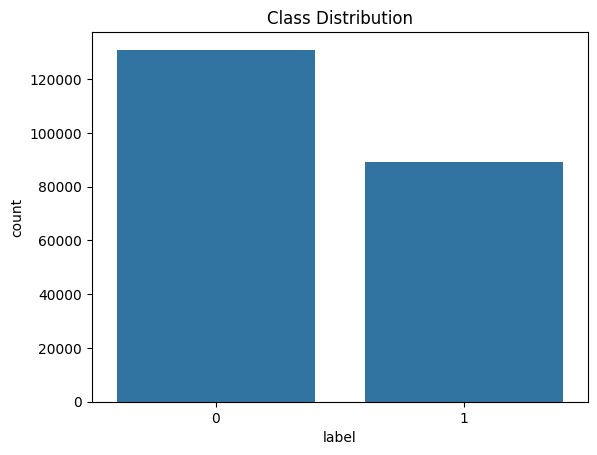

label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=all_labels_df)
plt.title('Class Distribution')
plt.show()
print(all_labels_df['label'].value_counts(normalize=True))

**View Sample Images**

Visualize some positive and negative samples.

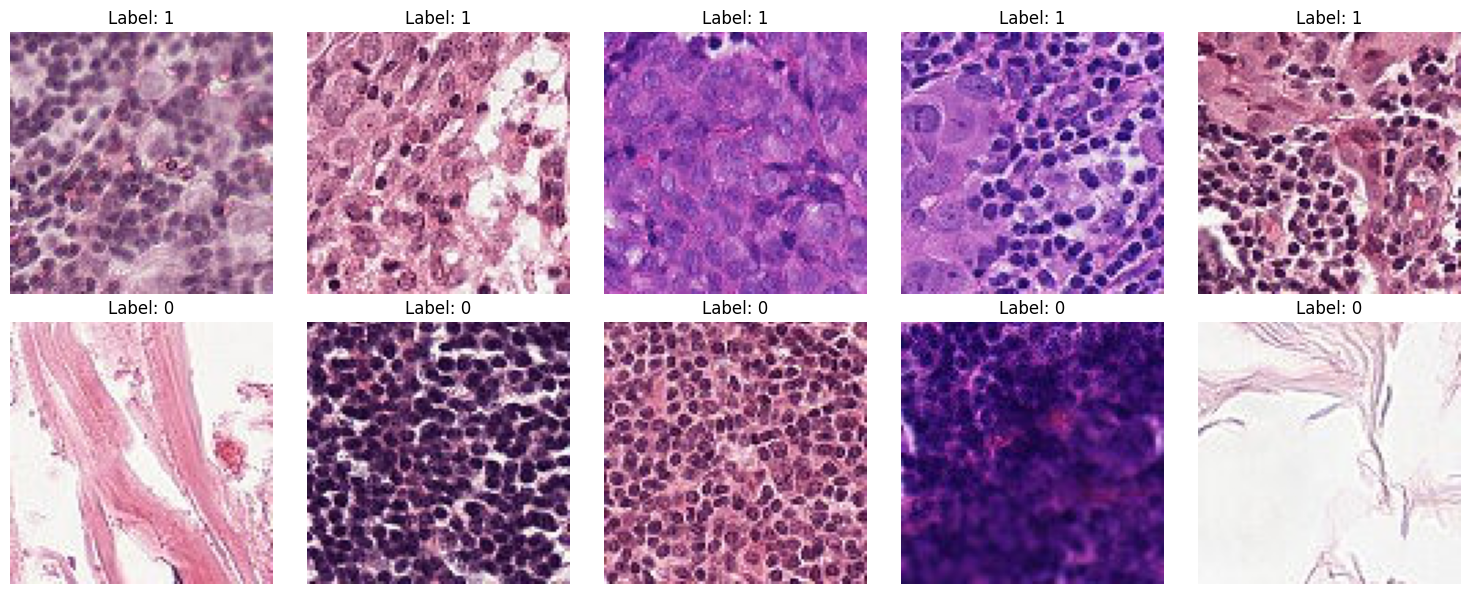

In [7]:
def plot_samples(df, n=5):
    """Plots n positive and n negative samples."""
    pos_samples = df[df['label'] == 1]['filename'].sample(n, random_state=SEED).values
    neg_samples = df[df['label'] == 0]['filename'].sample(n, random_state=SEED).values

    fig, axes = plt.subplots(2, n, figsize=(n*3, 6))

    for i in range(n):
        # Plot positive samples
        img_pos = plt.imread(pos_samples[i])
        axes[0, i].imshow(img_pos)
        axes[0, i].set_title("Label: 1")
        axes[0, i].axis('off')

        # Plot negative samples
        img_neg = plt.imread(neg_samples[i])
        axes[1, i].imshow(img_neg)
        axes[1, i].set_title("Label: 0")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot samples (only if not in debug mode, or if debug df is large enough)
if len(all_labels_df) > 10:
    plot_samples(all_labels_df)
else:
    print("Skipping sample plotting due to small debug dataframe.")

**Data Cleaning**

This dataset is known to contain anomalies (e.g., blank slides, slides with markers, duplicates). A simple cleaning step is to remove images with very low variance, as they are often blank.

Starting data cleaning (calculating variance)... This may take a while.
Utilizing 12 CPU cores for parallel variance calculation.


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  53 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 672 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 18432 tasks      | elapsed:    2.0s
[Parallel(n_jobs=12)]: Done 59904 tasks      | elapsed:    5.6s
[Parallel(n_jobs=12)]: Done 110592 tasks      | elapsed:    9.8s
[Parallel(n_jobs=12)]: Done 170496 tasks      | elapsed:   14.6s
[Parallel(n_jobs=12)]: Done 219372 tasks      | elapsed:   18.3s
[Parallel(n_jobs=12)]: Done 220025 out of 220025 | elapsed:   18.4s finished


Variance calculation complete.
Displaying 10 samples with the lowest variance...


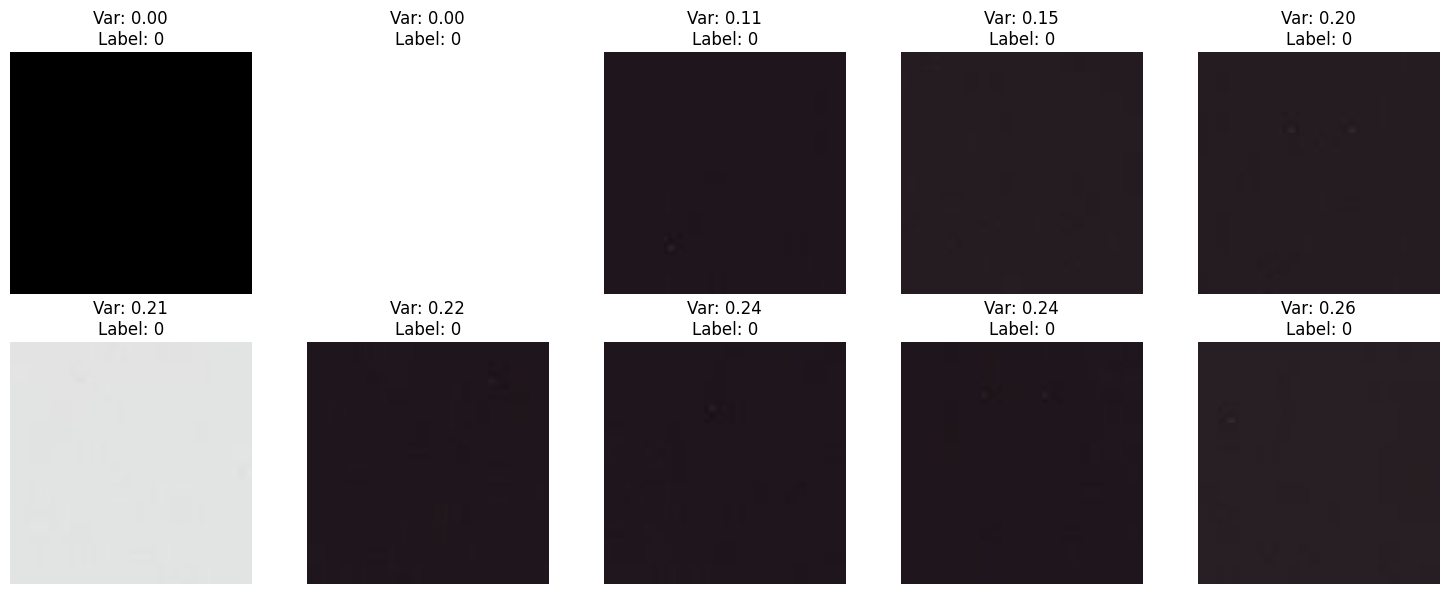

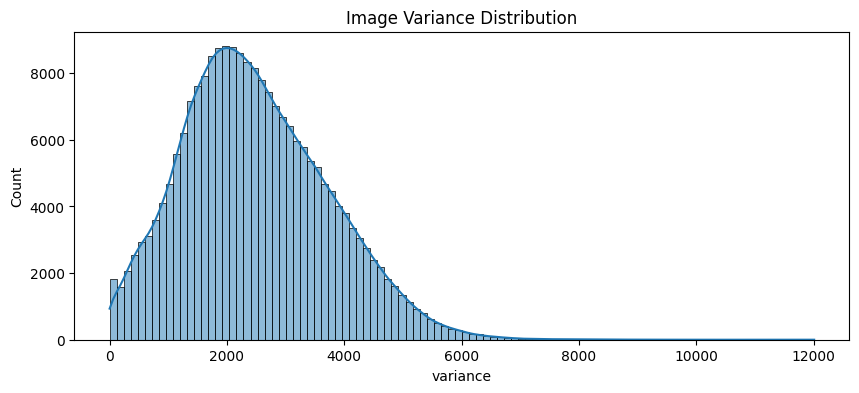

--- Data Cleaning Report ---
Original sample count (all_labels_df): 220025
Removed 1628 low-variance images (var < 100).
New sample count (all_labels_df_clean): 218397


In [8]:
# [CODE CELL]
import cv2 # <-- 重新导入以确保此单元格能独立运行
from joblib import Parallel, delayed # <-- 导入 Joblib
import os # <-- 导入 os 以获取 CPU 核心数
import matplotlib.pyplot as plt # <-- 导入 plt

# This step can be slow. For a quick run (DEBUG=True), we might skip it or run on the sample.
# For the full dataset, this should be run once.

def get_image_variance(image_path):
    """Calculates the variance of a single image."""
    try:
        # Read image in grayscale which is enough for variance calculation
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            return 0
        return image.var()
    except Exception as e:
        print(f"Error reading {image_path}: {e}")
        return 0

print("Starting data cleaning (calculating variance)... This may take a while.")

# --- 优化：并行处理 ---
# 利用 Colab Pro 的多核心 CPU 和高 RAM
# 替代慢速的: df_labels['file_path'].apply(get_image_variance)

n_cores = os.cpu_count()
print(f"Utilizing {n_cores} CPU cores for parallel variance calculation.")

paths_to_process = all_labels_df['filename'].values

# 使用 joblib 并行运行, verbose=5 会显示进度
variances = Parallel(n_jobs=n_cores, verbose=5)(
    delayed(get_image_variance)(path) for path in paths_to_process
)

# 将结果分配回 dataframe
all_labels_df['variance'] = variances

print("Variance calculation complete.")

# --- 1. (新增) 可视化方差最低的10个样本 ---
print("Displaying 10 samples with the lowest variance...")
low_variance_samples = all_labels_df.sort_values(by='variance').head(10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, (idx, row) in enumerate(low_variance_samples.iterrows()):
    try:
        img = plt.imread(row['filename'])
        axes[i].imshow(img)
        axes[i].set_title(f"Var: {row['variance']:.2f}\nLabel: {row['label']}")
        axes[i].axis('off')
    except Exception as e:
        axes[i].set_title(f"Error loading img: {row['id']}")
        print(e)
plt.tight_layout()
plt.show()

# Plot variance distribution
plt.figure(figsize=(10, 4))
sns.histplot(all_labels_df['variance'], bins=100, kde=True)
plt.title('Image Variance Distribution')
plt.show()

# --- 2. (修改) 过滤低方差图像并使用新变量 ---
VARIANCE_THRESHOLD = 100 # This is a common threshold, can be tuned
original_count = len(all_labels_df)

# 将清理后的数据存储在新 DataFrame 'df_labels_clean' 中
all_labels_df_clean = all_labels_df[all_labels_df['variance'] > VARIANCE_THRESHOLD].reset_index(drop=True)
new_count = len(all_labels_df_clean)

print(f"--- Data Cleaning Report ---")
print(f"Original sample count (all_labels_df): {original_count}")
print(f"Removed {original_count - new_count} low-variance images (var < {VARIANCE_THRESHOLD}).")
print(f"New sample count (all_labels_df_clean): {new_count}")



In [9]:

# --- 2. 数据加载与预处理 (使用 tf.data) ---


def parse_image(filename, label):
    """
    加载并预处理单个 PNG 图像。
    """
    image = tf.io.read_file(filename)

    # 关键更改：使用 decode_png，并确保 channels=3
    # 这将确保 (96, 96, 3) 的形状
    image = tf.io.decode_png(image, channels=3)

    # 我们不再需要复杂的 TIF 错误处理
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.image.convert_image_dtype(image, tf.float32)

    return image, label




def create_dataset(df, is_training=True):
    """
    根据 DataFrame 创建一个 tf.data.Dataset。
    """
    # 从 DataFrame 的 'filename' 和 'label' 列创建数据集
    dataset = tf.data.Dataset.from_tensor_slices((df['filename'].values, df['label'].values))

    # 使用多核并行处理图像
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        # 仅在训练时：
        # 1. 缓存数据（如果内存允许）
        # 2. 打乱数据
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=len(df), seed=SEED)

    # 批量处理
    dataset = dataset.batch(BATCH_SIZE)

    if not is_training:
        # 验证集在批处理后缓存，以加快评估速度
        dataset = dataset.cache()

    # 预取数据以获得最佳性能
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


# --- 3. 模型构建 ---

def build_augmentation_model():
    """
    创建包含 Keras 预处理层的数据增强模型。
    这将利用 GPU 进行加速。
    """
    return keras.Sequential([
        keras.layers.RandomFlip("horizontal_and_vertical", seed=SEED),
        keras.layers.RandomRotation(0.2, seed=SEED),
        keras.layers.RandomZoom(0.2, seed=SEED),
        keras.layers.RandomTranslation(0.2, 0.2, seed=SEED),
    ], name="augmentation_model")

def build_model(base_model_name, augmentation_model):
    """
    构建、编译一个用于快速比较的模型。
    主干网络将被冻结。
    """
    inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # 1. 数据增强层
    x = augmentation_model(inputs)

    # 2. 选择基础模型
    if base_model_name == 'EfficientNetV2B0':
        base_model = keras.applications.EfficientNetV2B0(
            include_top=False, weights='imagenet', input_tensor=x
        )
    elif base_model_name == 'MobileNetV3Small':
        base_model = keras.applications.MobileNetV3Small(
            include_top=False, weights='imagenet', input_tensor=x
        )
    elif base_model_name == 'ResNet50V2':
        base_model = keras.applications.ResNet50V2(
            include_top=False, weights='imagenet', input_tensor=x
        )
    else:
        raise ValueError(f"Unknown base model: {base_model_name}")

    # 3. 冻结主干网络
    base_model.trainable = False

    # 4. 添加分类头
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)
    # 二分类，使用 sigmoid 激活函数
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    # 5. 编译模型
    # 学习率先用一个标准值
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 竞赛的核心指标是 AUC
    metrics = [
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.AUC(name='auc')
    ]

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=metrics
    )

    return model




In [10]:
# --- 4. 主执行函数 ---

def main():

    # 拆分训练集和验证集 (80/20)
    # 使用 stratify 来保持标签分布
    train_df, val_df = train_test_split(
        all_labels_df_clean,
        test_size=0.2,
        random_state=SEED,
        stratify=all_labels_df_clean['label']
    )

    print(f"Total samples: {len(all_labels_df_clean)}")
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")

    # 2. 创建 tf.data pipelines
    print("Creating data pipelines...")
    train_dataset = create_dataset(train_df, is_training=True)
    val_dataset = create_dataset(val_df, is_training=False)
    print("Data pipelines created.")

    # 3. 定义要比较的模型
    # 选择一些轻量级且性能优秀的基础模型
    models_to_try = ['MobileNetV3Small', 'EfficientNetV2B0', 'ResNet50V2']
    histories = {}

    # 4. 构建数据增强
    augmentation_model = build_augmentation_model()

    # 5. 循环训练和评估模型
    print("Starting model training loop...")

    # 定义回调
    callbacks = [
        # 监控 val_auc，5 个 epoch 没有提升就停止
        keras.callbacks.EarlyStopping(
            monitor='val_auc',
            patience=5,
            mode='max',
            restore_best_weights=True
        ),
        # 当 val_auc 停滞时，自动降低学习率
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.2,
            patience=2,
            mode='max'
        )
    ]

    for model_name in models_to_try:
        print(f"\n--- Training {model_name} ---")
        # 清理 Keras 会话，释放内存
        keras.utils.clear_session()

        model = build_model(model_name, augmentation_model)

        # if model_name == models_to_try[0]:
        # model.summary()  # 只打印第一个模型的摘要

        history = model.fit(
            train_dataset,
            epochs=EPOCHS,
            validation_data=val_dataset,
            callbacks=callbacks,
            verbose=1  # 打印进度
        )

        histories[model_name] = history
        best_val_auc = max(history.history['val_auc'])
        print(f"--- Best Validation AUC for {model_name}: {best_val_auc:.5f} ---")

    # 6. 总结结果
    print("\n--- Model Comparison Summary (Best Val AUC) ---")
    summary_results = {}
    for model_name, history in histories.items():
        best_auc = max(history.history['val_auc'])
        summary_results[model_name] = best_auc
        print(f"{model_name}: {best_auc:.5f}")

    best_model_name = max(summary_results, key=summary_results.get)
    print(f"\n--- Best Performing Model: {best_model_name} ---")

    print("\nStep 1 (Model Selection) Complete.")
    print(f"Next step: Take '{best_model_name}' and move to Step 2 (Fine-Tuning & Hyperparameter Tuning).")


if __name__ == '__main__':
    main()

Total samples: 218397
Training samples: 174717
Validation samples: 43680
Creating data pipelines...
Data pipelines created.
Starting model training loop...

--- Training MobileNetV3Small ---


/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 44s 409ms/step - accuracy: 0.5763 - auc: 0.5905 - loss: 0.8134 - val_accuracy: 0.7470 - val_auc: 0.8191 - val_loss: 0.5412 - learning_rate: 0.0010
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.7380 - auc: 0.7981 - loss: 0.5512 - val_accuracy: 0.7774 - val_auc: 0.8583 - val_loss: 0.4922 - learning_rate: 0.0010
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.7711 - auc: 0.8386 - loss: 0.4894 - val_accuracy: 0.7868 - val_auc: 0.8734 - val_loss: 0.4679 - learning_rate: 0.0010
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.7869 - auc: 0.8576 - loss: 0.4602 - val_accuracy: 0.7894 - val_auc: 0.8786 - val_loss: 0.4581 - learning_rate: 0.0010
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.7926 - auc: 0.8643 - loss: 0.4494 - val_accuracy: 0.7908 - val_auc: 0.8834 - val_loss: 0.4511 - learning_rate: 0.0010
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.7955 - auc: 0